In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

In [2]:
L = 100

class Body():

    def __init__(self, x0, y0, box_size=L, sigma=0.02, inf_dist=2):
        self.box_size = box_size
        self.x = x0
        self.y = y0
        self.sigma = sigma
        self.loc_history = [(x0, y0)]
        self.is_sick = False
        self.health_history = [False]
        self.inf_dist = inf_dist

    def add_to_loc_history(self, x, y):
        self.loc_history.append((x, y))

    def add_to_health_history(self, x):
        self.health_history.append(x)

    def get_infected(self):
        self.is_sick= True

    @staticmethod
    def new_position(z, dz, box_size):
        
        zhat = abs(z + dz)
        
        if(zhat > box_size):
            zhat = 2*box_size - zhat 
        
        return zhat 

    def move(self):
        sigma = self.sigma *self.box_size
        dx = np.random.normal(loc=0.0, scale=sigma)
        dy = np.random.normal(loc=0.0, scale=sigma)

        self.x = Body.new_position(z=self.x, dz=dx, box_size=self.box_size)
        self.y = Body.new_position(z=self.y, dz=dy, box_size=self.box_size)

        self.add_to_loc_history(self.x, self.y)

    def distance(self, other): 

        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def interact(self, other):
        
        dist = self.distance(other)
        status = self.is_sick + other.is_sick

        if ((status % 2) != 0):

            if (self.is_sick):
                prob = np.exp(-dist/self.inf_dist)
                change_status = np.random.binomial(n=1, p=prob)

                if (change_status):
                    other.get_infected()
            
            else: 
                prob = np.exp(-dist/other.inf_dist)
                change_status = np.random.binomial(n=1, p=prob)

                if (change_status):
                    self.get_infected()

In [3]:
b1 = Body(0, 0)
b2 = Body(.5, 0)
b2.get_infected()
b1.interact(b2)
print(b1.is_sick)
print(b1.health_history)

True
[False]


In [11]:
class Simulation():

    def __init__(self, n_bodies, num, l=L):
        self.box_size = l
        self.n_bodies = n_bodies
        self.num = num
        self.bodies  = [
            Body(
                x0=np.random.uniform(low=0.0, high=self.box_size), 
                y0=np.random.uniform(low=0.0, high=self.box_size),
                box_size=self.box_size
            )
            for i in range(0, self.n_bodies)
        ]
        self.hist_len = 1

    def run(self):

        self.bodies[0].get_infected()

        for i in range(self.num):

            for j, b1 in enumerate(self.bodies):

                for k, b2 in enumerate(self.bodies):

                    if (j < k):
                        
                        b1.interact(b2)

            [b.add_to_health_history(b.is_sick) for b in self.bodies]
            [b.move() for b in self.bodies]

        self.hist_len = self.hist_len + self.num

    def animate(self):

        fig, ax = plt.subplots()
        ax.set(title='Animation', xlim=(0, self.box_size), ylim=(0, self.box_size))

        scat = ax.scatter(x=[], y=[], c='black')

        def update(i):
            x = [b.loc_history[i][0] for b in self.bodies]
            y = [b.loc_history[i][1] for b in self.bodies]

            x = np.array(x).reshape(-1, 1)
            y = np.array(y).reshape(-1, 1)
            
            health_history = np.array([b.health_history for b in self.bodies])[:, i].astype(float)
            
            scat.set_offsets(np.concatenate((x, y), axis=1))
            #scat.set_array(np.array([b.is_sick for b in self.bodies]))
            #scat.set_array(health_history)
            scat.set_edgecolors(np.array([(1,0,0,1) if b.health_history[i]  else(0,1,0,1) for b in sim.bodies]))
            #scat.set_array(np.random.normal(0, 1, self.num))
            
            return scat, 
        
        anim = FuncAnimation(fig, update, frames=self.hist_len, interval=200, blit=True)
        return anim 

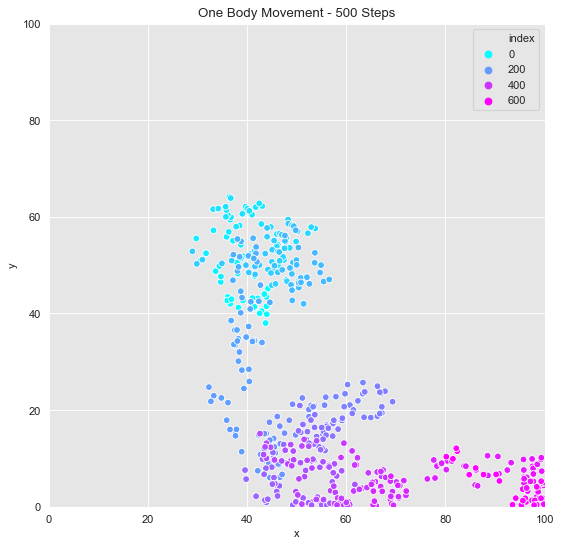

In [12]:
sim_1 = Simulation(n_bodies=1, num=500)
sim_1.run()

body_history_df = pd.DataFrame(sim_1.bodies[0].loc_history, columns=['x', 'y']).reset_index()

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', hue='index', palette='cool', data=body_history_df, ax=ax)
ax.legend()
ax.set(title=f'One Body Movement - {sim_1.num} Steps', xlim=(0.0, L), ylim=(0.0, L));

In [13]:
sim = Simulation(n_bodies=200, num=100)
sim.run()

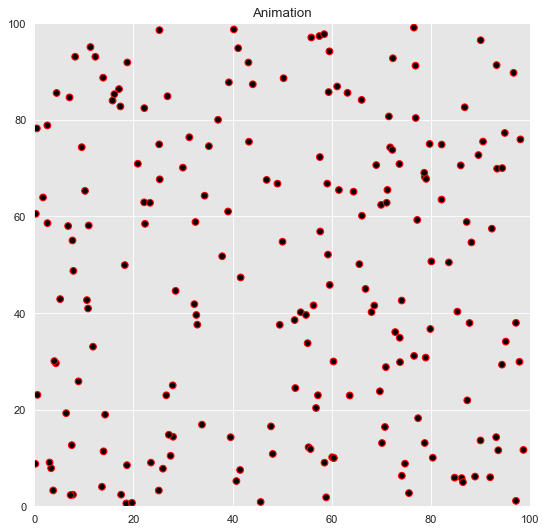

In [14]:
HTML(sim.animate().to_jshtml())